# url 및 가게 이름 입력으로 review 및 predict 구하기

### 모듈 import 및 함수정의

In [10]:
!pip install transformers
!pip install sentencepiece
!pip install tensorflow_addons

In [11]:
import pandas as pd 
from selenium import webdriver 
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By

import time
import re 
from bs4 import BeautifulSoup 
from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import sentencepiece as spm
import tensorflow_addons as tfa
import logging  # logging 모듈을 import 합니다.
tf.get_logger().setLevel(logging.ERROR)  # tensorflow의 logger를 ERROR 레벨로 설정합니다.


In [12]:

def set_url(name,url):

    # url 지정
    df_url = url
    name = name

    # 검색에 사용할 url 생성
    res_code = re.findall(r"place/(\d+)", df_url)  # 정규표현식으로 플레이스 코드 추출
    final_url = 'https://pcmap.place.naver.com/restaurant/' + \
        res_code[0]+'/review/visitor#'  # 리뷰 페이지 url 만들기
    
    return name, final_url


In [13]:
def review_crwal(name,final_url):
    # 웹드라이버 접속
    driver = webdriver.Chrome(executable_path='C:/Users/ysj_1/Documents/ds_study/driver/chromedriver.exe') # 웹드라이버가 설치된 경로를 지정해주시면 됩니다.

    rating_list = []    # rating

    time.sleep(2) 


    # 식당 리뷰 개별 url 접속
    driver.get(final_url) 
    thisurl = final_url
    time.sleep(2) 

    # 더보기 버튼 다 누를 것
    # 더보기 버튼은 10개 마다 나옴
    cnt = 0
    while True: 
        try: 
            last_height = driver.execute_script("return document.body.scrollHeight")
            time.sleep(0.7)
            driver.find_element(by=By.TAG_NAME, value='body').send_keys(Keys.END) 
            time.sleep(0.7)

            driver.find_element(by=By.CSS_SELECTOR, value='#app-root > div > div > div > div:nth-child(7) > div:nth-child(3) > div:nth-child(3) > div.lfH3O > a').send_keys(Keys.ENTER)
            time.sleep(0.7) 
            driver.find_element(by=By.TAG_NAME, value='body').send_keys(Keys.END) 
            time.sleep(0.7)
            driver.find_element(by=By.CSS_SELECTOR, value='#app-root > div > div > div > div:nth-child(7) > div:nth-child(3) > div:nth-child(3) > div.lfH3O > a').send_keys(Keys.ENTER)
            time.sleep(0.7)
            new_height = driver.execute_script("return document.body.scrollHeight") 

            if new_height == last_height:
                if cnt >= 10:
                    break
                else:
                    cnt += 1
                    continue

        except NoSuchElementException: 
            print('-더보기 버튼 모두 클릭 완료-') 
            break 


    # 파싱
    html = driver.page_source 
    soup = BeautifulSoup(html, 'lxml') 
    time.sleep(1) 

    # 식당 구분 
    restaurant_name = name
    print('식당 이름 : '+ name) 



    # 특정 식당에 대한 리뷰 수집
    try: 
        one_review = soup.find_all('li', attrs = {'class':'YeINN'})
        review_num = len(one_review) # 특정 식당의 리뷰 총 개수 
        print('리뷰 총 개수 : '+str(review_num)) 

        # 모든 리뷰에 대해서 정보 수집
        for j in range(len(one_review)): 

            # rating, 별점 
            try:
                rating = rating = one_review[j].find('span', attrs = {'class':'P1zUJ HNG_1'}).text
            except:
                rating = '별점없음'

            # date 
            # 사진 리뷰 없음 
            if len(one_review[j].find_all('span', attrs = {'class':'P1zUJ'})) == 5: 
                date = one_review[j].find_all('span', attrs = {'class':'P1zUJ'})[2].text 

            elif len(one_review[j].find_all('span', attrs = {'class':'P1zUJ'})) == 6: 
                date = one_review[j].find_all('span', attrs = {'class':'P1zUJ'})[3].text
            else: 
                date = ""
            # print('date = '+date)


            # review 내용
            try: 
                review_content = one_review[j].find('span', attrs = {'class':'zPfVt'}).text
            except: # 리뷰가 없다면
                review_content = "" 

            # rating_df_url_list 
            naver_review = {'restaurant_name' : restaurant_name,'review_content' : review_content, 'rating' : rating, 'date' : date}
            rating_list.append(naver_review) 

    # 리뷰가 없는 경우        
    except NoSuchElementException: 
        none_review = "네이버 리뷰 없음" 
        # print(none_review)
        review_num = 0 

        # rating_df_url_list
        naver_review = {'restaurant_name' : restaurant_name,'review_content' : none_review, 'rating' : none_review, 'date' : none_review}
        rating_list.append(naver_review)


    print('----------------------------------------------') 

    print('\n')
    driver.quit()
    
    result = pd.DataFrame(rating_list)
    result.reset_index(drop=True, inplace=True)
    
    return result


In [14]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', } 


def clean(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text.strip()


import re


def clean_str(text):
    pattern = '([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)' # E-mail제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+' # URL제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)'  # 한글 자음, 모음 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '<[^>]*>'         # HTML 태그 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '[^\w\s\n]'         # 특수기호제거
    text = re.sub(pattern=pattern, repl='', string=text)
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','', string=text)
    text = re.sub('\n', '.', string=text)
    return text 



# KoBERT 토크나이저를 활용 

import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer


logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}

SPIECE_UNDERLINE = u'▁'


class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece `_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt
    

def sentence_convert_data(data):
    global tokenizer
    tokens, masks, segments = [], [], []
    token = tokenizer.encode(data, max_length=SEQ_LEN,
                             truncation=True, padding='max_length')

    num_zeros = token.count(0)  # 패딩으로 추가된 0의 개수를 세어준다.
    mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros  # 패딩 부분은 0으로 마스킹한다.
    segment = [0]*SEQ_LEN  # 문장의 길이만큼 segment를 0으로 채운다.

    tokens.append(token)
    segments.append(segment)
    masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]


def review_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = sentiment_model.predict(data_x)
    predict_value = np.ravel(predict)
    predict_answer = np.round(predict_value, 0).item()

    # if predict_answer == 0:
    #   # 예측값이 0일 경우, 부정적인 평가로 판단한다.
    #   print(sentence)
    #   print("(부정 확률 : %.2f) 부정적인 평가입니다." % (1-predict_value))
    #   print('='*60)
    # elif predict_answer == 1:
    #   # 예측값이 1일 경우, 긍정적인 평가로 판단한다.
    #   print(sentence)
    #   print("(긍정 확률 : %.2f) 긍정적인 평가입니다." % predict_value)
    #   print('='*60)
    return predict

    
SEQ_LEN = 64
BATCH_SIZE = 32
# 긍부정 문장을 포함하고 있는 칼럼
DATA_COLUMN = "review_content"
# 긍정인지 부정인지를 (1=긍정,0=부정) 포함하고 있는 칼럼
LABEL_COLUMN = "rating"

In [15]:
def model_set(df):

    # df_no_star = df_no_star.drop_duplicates(subset='review_content')
    df.dropna(subset='review_content',inplace=True)
    df.loc[:,'review_content'] = df['review_content'].apply(lambda x : clean(x,punct,punct_mapping)).copy()
    df.loc[:,'review_content'] = df['review_content'].apply(lambda x : clean_str(x)).copy()
    df_no_star = df.copy()


    tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')
    model = TFBertModel.from_pretrained(
        "monologg/kobert", from_pt=True)  # monologg/kobert 모델 불러오기
    


    # 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
    token_inputs = tf.keras.layers.Input(
        (SEQ_LEN,), dtype=tf.int32, name='input_word_ids')  # 입력 토큰 정의
    mask_inputs = tf.keras.layers.Input(
        (SEQ_LEN,), dtype=tf.int32, name='input_masks')  # 입력 마스크 정의
    segment_inputs = tf.keras.layers.Input(
        (SEQ_LEN,), dtype=tf.int32, name='input_segment')  # 입력 세그먼트 정의


    # 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
    bert_outputs = model(
        [token_inputs, mask_inputs, segment_inputs])  # bert 모델의 출력 정의

    bert_outputs = bert_outputs[1]

    # 총 batch size * 4 epoch = 2344 * 4
    # Rectified Adam 옵티마이저 생성
    opt = tfa.optimizers.RectifiedAdam(
        lr=5.0e-5,  # learning rate 설정
        total_steps=2344*2,  # 총 스텝 수 설정
        warmup_proportion=0.1,  # warmup 비율 설정
    )


    sentiment_drop = tf.keras.layers.Dropout(
        0.5)(bert_outputs)  # BERT 출력값에 드롭아웃 적용
    sentiment_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(
        stddev=0.02))(sentiment_drop)  # 드롭아웃 적용된 BERT 출력값에 fully connected layer 적용
    sentiment_model = tf.keras.Model(
        [token_inputs, mask_inputs, segment_inputs], sentiment_first)  # 입력값과 출력값을 지정하여 모델 생성
    sentiment_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=[
                            'acc'])  # 모델 컴파일, optimizer는 Adam, loss는 binary crossentropy, 평가 지표는 accuracy

    sentiment_model.load_weights('./판별기/ckpt_eda_data')
    df_no_star = df_no_star.copy()
    df_no_star['predict_proba'] = np.nan
    df_no_star.reset_index(drop=True,inplace=True)
    
    return df_no_star,sentiment_model,tokenizer



In [16]:
def review_pred(df_no_star):

    for idx in tqdm(range(len(df_no_star)), leave=True):
        predict = review_evaluation_predict(df_no_star['review_content'][idx])
        df_no_star.loc[idx,'predict_proba'] = predict[0][0]
        if idx % 500 == 0:
            df_no_star.to_csv(f'saved_to_{idx}.csv')


    df_add_score_tmp = df_no_star.copy()

    df_add_score_tmp.loc[df_add_score_tmp['predict_proba'] > 0.5,'pred_0.5'] = '긍정'
    df_add_score_tmp.loc[df_add_score_tmp['predict_proba'] <= 0.5,'pred_0.5'] = '부정'
    df_add_score_tmp[df_add_score_tmp['pred_0.5'] == '부정']

    df_add_score = df_add_score_tmp.copy()

    df_add_score.to_csv('predict_result.csv')
    
    return df_add_score



In [17]:
def get_pred(input_name, input_url):
    name, final_url = set_url(input_name,input_url)

    df = review_crwal(name,final_url)
    
    global sentiment_model,tokenizer

    df_no_star,sentiment_model,tokenizer = model_set(df)

    df_add_score = review_pred(df_no_star)
    
    return df_add_score

In [18]:
def print_result(df_add_score):
    from konlpy.tag import Okt
    from tqdm import tqdm
    from collections import Counter
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    
    print('******************* Print Result : {} *******************'.format(df_add_score.loc[0,'restaurant_name']))
    print('* 긍/부정 count')
    print('='*90)
    df_add_score = df_add_score[df_add_score['review_content'].notnull()]

    tmp = df_add_score['pred_0.5'].value_counts().reset_index().rename(columns={'pred_0.5':'count'})
    display(tmp)
    print('='*90)
    print('='*90)
    
    
    # 부정어 워드 클라우드
    #긍정과 부정 데이터프레임 나누기
    print('* 부정리뷰 워드클라우드')
    df_pros = df_add_score[df_add_score['pred_0.5'] == '긍정'].copy()
    df_cons = df_add_score[df_add_score['pred_0.5'] == '부정'].copy()

    # 부정도 진행
    df_cons['review_content'] = df_cons['review_content'].astype(str)

    # 불용어 지정 - 기존과 변경
    stopwords = ['의', '가', '이', '은', '들', '는', '과', '도', '를', '으로', '에','하다', '을', '이다', '것', '로', '에서', '그', '인', '서', '네요','임', '랑', '게', '요', '에게', '엔','.','1','2','3','4','5','6','7','8','9','0', '어요','너무','다','가다','나','있다', '나다', '고', '면', '제', '만', '까지', '적']


    okt = Okt()

    review_pros = []
    for sentence in tqdm(df_pros['review_content']):
        tokenized_sentence = okt.morphs(sentence) # 토큰화
        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
        review_pros.append(stopwords_removed_sentence)

    # 리스트 안의 리스트 데이터 리스트 하나로 풀어주기
    nouns_pros = []
    for i in review_pros:
        for j in i:
            nouns_pros.append(j)

    # counter 이용하여 상위 단어 추출

    font = 'C:\Windows\Fonts\malgun.ttf'

    pros_counts = Counter(nouns_pros)
    tags = pros_counts.most_common(30)

    # 윈도우 기준 워드클라우드 그리기
    print('='*80)
    print('긍정 워드클라우드')
    try:
        word_cloud = WordCloud(font_path=font, background_color='white', max_font_size=400, colormap='nipy_spectral').generate_from_frequencies(dict(tags))

        plt.figure(figsize=(10,8))
        plt.imshow(word_cloud)
        plt.axis('off')
        plt.show()
    except:
        print('생성불기')


    review_cons = []
    for sentence in tqdm(df_cons['review_content']):
        tokenized_sentence = okt.nouns(sentence) # 토큰화
        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
        review_cons.append(stopwords_removed_sentence)

    morphs_cons = []
    for i in review_cons:
        for j in i:
            morphs_cons.append(j)


    counts = Counter(morphs_cons)
    del counts['두']
    del counts['수']
    del counts['이라']
    del counts['그리고']
    del counts['거']
    tags = counts.most_common(30)

    
    try :

        word_cloud = WordCloud(font_path=font, background_color='white', max_font_size=400, colormap='nipy_spectral').generate_from_frequencies(dict(tags))
        print('='*80)
        print('부정 워드클라우드')
        plt.figure(figsize=(10,8))
        plt.imshow(word_cloud)
        plt.axis('off')
        plt.show()


        # 긍정리뷰 비율
        total = tmp[tmp['index'] == '긍정']['count'].values[0]  + tmp[tmp['index'] == '부정']['count'].values[0]
        positive = tmp[tmp['index'] == '긍정']['count'].values[0] 
        print('* 긍정리뷰 비율 : ',positive/total)
        print('='*90)
        print('='*90)
        
        
        # 긍정확률 평균
        print('* 긍정확률 평균 : ',df_add_score['predict_proba'].mean())
        print('='*90)
        print('='*90)
        
        
        # 부정리뷰 출력
        print('* 부정 review')
        print('='*90)
        for idx, each in enumerate(df_add_score[df_add_score['pred_0.5'] == '부정']['review_content']):
            print(f'*** {idx+1} ***')
            print(each)
            print('='*100)
        
    except :
        print('부정리뷰 없음!!!')

### 함수 실행

#### input_url은 네이버 지도에서 검색 뒤 target 음식점을 클릭하여 해당음식점의 탭이 추가로 생성된 다음 url을 복사하여 사용한다.
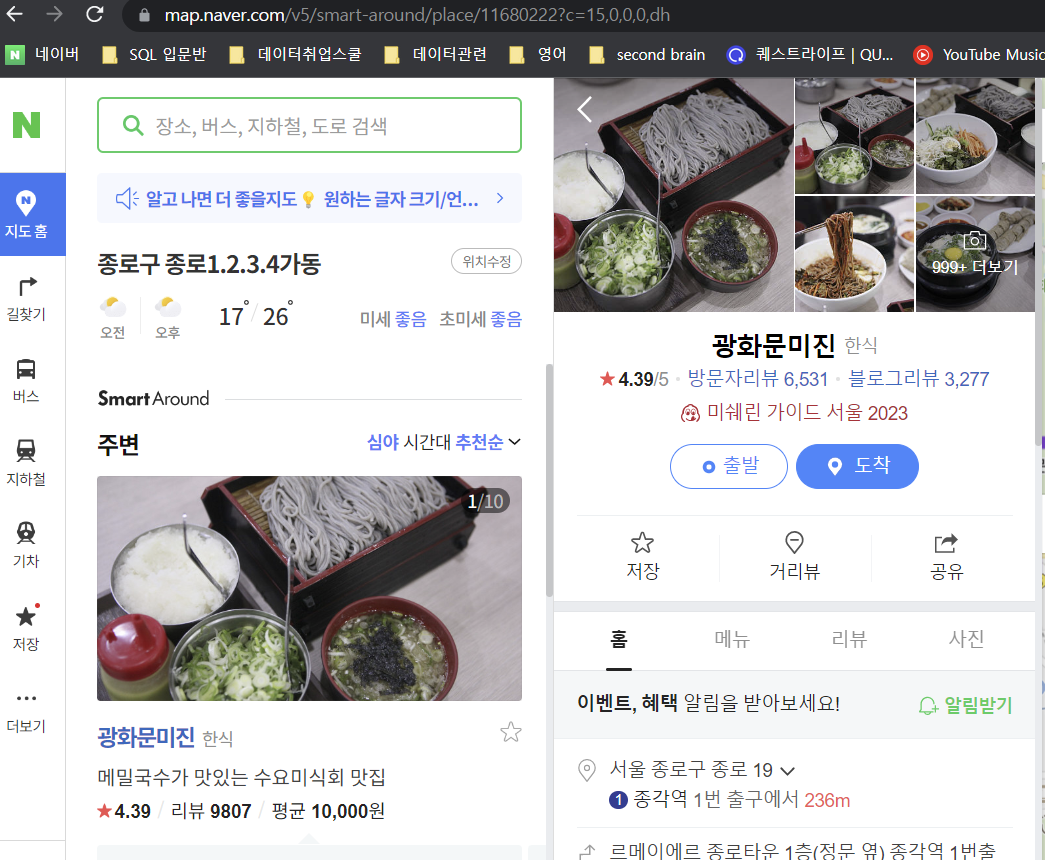


In [23]:
input_url = input('url을 입력하세요.')
input_name =  input('음식점명을 입력하세요.')

# url과 음식점 이름을 입력하면 리뷰를 크롤링 후 prdiec해서 데이터프레임으로 반환한다.

df_add_score = get_pred(input_name, input_url)
df_add_score

-더보기 버튼 모두 클릭 완료-
식당 이름 : 백팥집
리뷰 총 개수 : 201
----------------------------------------------




loading file tokenizer_78b3253a26.model from cache at C:\Users\ysj_1/.cache\huggingface\hub\models--monologg--kobert\snapshots\30941062c0f3dde73b246468f449f2448c7694bc\tokenizer_78b3253a26.model
loading file vocab.txt from cache at C:\Users\ysj_1/.cache\huggingface\hub\models--monologg--kobert\snapshots\30941062c0f3dde73b246468f449f2448c7694bc\vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at C:\Users\ysj_1/.cache\huggingface\hub\models--monologg--kobert\snapshots\30941062c0f3dde73b246468f449f2448c7694bc\tokenizer_config.json
loading configuration file config.json from cache at C:\Users\ysj_1/.cache\huggingface\hub\models--monologg--kobert\snapshots\30941062c0f3dde73b246468f449f2448c7694bc\config.json
Model config BertConfig {
  "_name_or_path": "monologg/kobert",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,

,restaurant_name,review_content,rating,date,predict_proba,pred_0.5
0,백팥집,옛날팥빙수 7 5 팥이 많이 달지 않고 빙수가 정말 맛있어요 떡도 말...,별점없음,,0.997320,긍정
1,백팥집,안타깝게도 8월21일부터 한달간 임시휴업하신다네요 건강찾으시고 다시 맛있게 해주...,별점없음,,0.936013,긍정
2,백팥집,드디어 녹차빙수 예쁘게 찍었음 .녹차 빙수는 속을 살살 파 먹다가 쌉쌀한 맛이 질...,별점없음,,0.995331,긍정
3,백팥집,1인 1빙수는 무리였네요 그래도 맛있게 잘 먹고 갑니다 통팥인데다가 부드럽네요,별점없음,,0.974753,긍정
4,백팥집,부산동래 팥빙수전문점이에요 건물 1층이 매장 2 3층은 팥연구소 팥...,별점없음,,0.995313,긍정
...,...,...,...,...,...,...
196,백팥집,맛나요,별점없음,,0.878212,긍정
197,백팥집,Good,별점없음,,0.882388,긍정
198,백팥집,너무맛있어요 가격도착하구,별점없음,,0.996837,긍정
199,백팥집,최애,별점없음,,0.965115,긍정


******************* Print Result : 백팥집 *******************
* 긍/부정 count


,index,count
0,긍정,190
1,부정,11


* 부정리뷰 워드클라우드


100%|██████████| 190/190 [00:04<00:00, 41.69it/s] 


긍정 워드클라우드


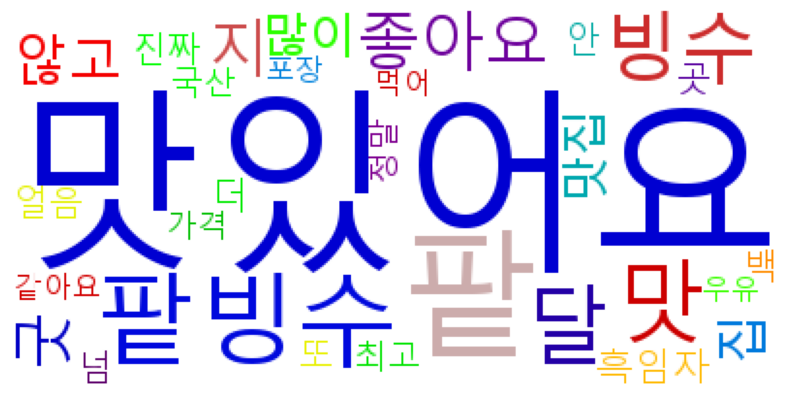

100%|██████████| 11/11 [00:00<00:00, 430.03it/s]


부정 워드클라우드


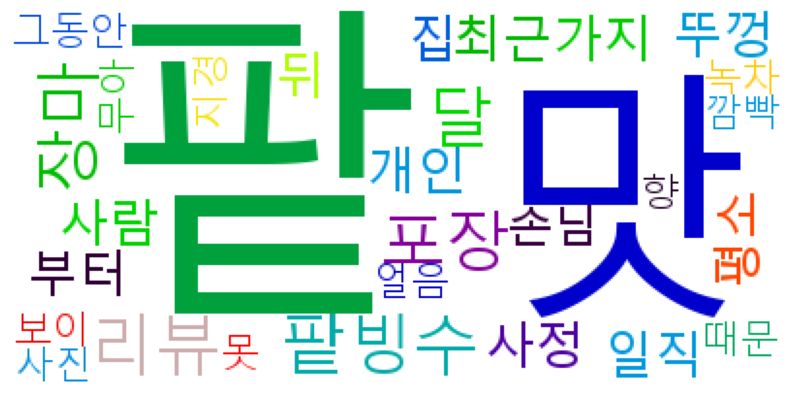

* 긍정리뷰 비율 :  0.945273631840796
* 긍정확률 평균 :  0.882319850856392
* 부정 review
*** 1 ***
믿고 먹는 팥빙수 집     일직가지 않으면 사람이 많아 포장을 할수 밖에 없네요     그래도 포장도 꼼꼼하게 해서 .맛도 같습니다   뚜껑을 닫아서 팥이 눌러져 그렇지만 맛은 같아요   8    21부터 한달간 개인사정상 쉰다고 하시.네요   아쉽지만 한달 뒤를 기다리겠습니다 
*** 2 ***
최근에 바빠서 너무 오랫만에 갔네요   장마라 그런지 평소에 비해 손님이 너무 적으셨어요   .그동안 장마 때문에 못 가셨던 분들   참을만큼 참지 않았나요     일어나라 백팥으로 향하라 
*** 3 ***
아     녹차가 보이게 얼음 사진 찍는 거 깜빡       무아지경에 빠질 만도 하지   백팥이니까 
*** 4 ***
팥이 달아요   단것을 그다지 좋아하지 않아 재방문은 없을듯
*** 5 ***
아니 리뷰 나만 올리나      .저를 팔로우하시는 이름 모를 분들 여긴 꼭 가 보세요 
*** 6 ***
적어도 기본으로 먹을 때는 팥 추가 
*** 7 ***
보통의 팥빙수라 다른 맛  .맛집 인정
*** 8 ***
리뷰가 좋아 기대하고 갔는데.별로임
*** 9 ***
ᆞ
*** 10 ***
ᆞ
*** 11 ***
맛있어요    담백하고


In [21]:
print_result(df_add_score)

## 예측하기

In [47]:
# 예측을 위한 모델 셋팅 및 불러오기

def model_set_for_pred():


    tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')
    model = TFBertModel.from_pretrained(
        "monologg/kobert", from_pt=True)  # monologg/kobert 모델 불러오기
    


    # 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
    token_inputs = tf.keras.layers.Input(
        (SEQ_LEN,), dtype=tf.int32, name='input_word_ids')  # 입력 토큰 정의
    mask_inputs = tf.keras.layers.Input(
        (SEQ_LEN,), dtype=tf.int32, name='input_masks')  # 입력 마스크 정의
    segment_inputs = tf.keras.layers.Input(
        (SEQ_LEN,), dtype=tf.int32, name='input_segment')  # 입력 세그먼트 정의


    # 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
    bert_outputs = model(
        [token_inputs, mask_inputs, segment_inputs])  # bert 모델의 출력 정의

    bert_outputs = bert_outputs[1]

    # 총 batch size * 4 epoch = 2344 * 4
    # Rectified Adam 옵티마이저 생성
    opt = tfa.optimizers.RectifiedAdam(
        lr=5.0e-5,  # learning rate 설정
        total_steps=2344*2,  # 총 스텝 수 설정
        warmup_proportion=0.1,  # warmup 비율 설정
    )


    sentiment_drop = tf.keras.layers.Dropout(
        0.5)(bert_outputs)  # BERT 출력값에 드롭아웃 적용
    sentiment_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(
        stddev=0.02))(sentiment_drop)  # 드롭아웃 적용된 BERT 출력값에 fully connected layer 적용
    sentiment_model = tf.keras.Model(
        [token_inputs, mask_inputs, segment_inputs], sentiment_first)  # 입력값과 출력값을 지정하여 모델 생성
    sentiment_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=[
                            'acc'])  # 모델 컴파일, optimizer는 Adam, loss는 binary crossentropy, 평가 지표는 accuracy

    sentiment_model.load_weights('./판별기/ckpt_eda_data')

    
    return sentiment_model,tokenizer



In [48]:
# 문장 예측을 전처리 및 모델을 이용하는 함수 호출

def sentence_convert_data(data):
    global tokenizer
    tokens, masks, segments = [], [], []
    token = tokenizer.encode(data, max_length=SEQ_LEN,
                             truncation=True, padding='max_length')

    num_zeros = token.count(0)  # 패딩으로 추가된 0의 개수를 세어준다.
    mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros  # 패딩 부분은 0으로 마스킹한다.
    segment = [0]*SEQ_LEN  # 문장의 길이만큼 segment를 0으로 채운다.

    tokens.append(token)
    segments.append(segment)
    masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]


def review_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = sentiment_model.predict(data_x)
    predict_value = np.ravel(predict)
    predict_answer = np.round(predict_value, 0).item()

    print('='*50)
    print('예측문장 : ',sentence)

    if predict_answer == 0:
      # 예측값이 0일 경우, 부정적인 평가로 판단한다.
      print("(부정 확률 : %.2f) 부정적인 평가입니다." % (1-predict_value))
    elif predict_answer == 1:
      # 예측값이 1일 경우, 긍정적인 평가로 판단한다.
      print("(긍정 확률 : %.2f) 긍정적인 평가입니다." % predict_value)

In [49]:
# 예측 모델 부르기

sentiment_model,tokenizer = model_set_for_pred()

loading file tokenizer_78b3253a26.model from cache at C:\Users\ysj_1/.cache\huggingface\hub\models--monologg--kobert\snapshots\30941062c0f3dde73b246468f449f2448c7694bc\tokenizer_78b3253a26.model
loading file vocab.txt from cache at C:\Users\ysj_1/.cache\huggingface\hub\models--monologg--kobert\snapshots\30941062c0f3dde73b246468f449f2448c7694bc\vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at C:\Users\ysj_1/.cache\huggingface\hub\models--monologg--kobert\snapshots\30941062c0f3dde73b246468f449f2448c7694bc\tokenizer_config.json
loading configuration file config.json from cache at C:\Users\ysj_1/.cache\huggingface\hub\models--monologg--kobert\snapshots\30941062c0f3dde73b246468f449f2448c7694bc\config.json
Model config BertConfig {
  "_name_or_path": "monologg/kobert",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,

In [50]:
# 예측할 문장 정의

pos_text = '팥이 너무 달지 않아서 잘 맛있게 잘 먹었어요.'
neg_text = '평소 맛있어서 포장했는데, 포장이 잘 안됐는지 집에 와보니 다 녹아서 거의 먹지도 못했네요.'



In [51]:
# 긍정 문장 예측

review_evaluation_predict(pos_text)

예측문장 :  팥이 너무 달지 않아서 잘 맛있게 잘 먹었어요.
(긍정 확률 : 0.99) 긍정적인 평가입니다.


In [52]:
# 부정 문장 예측

review_evaluation_predict(neg_text)

예측문장 :  평소 맛있어서 포장했는데, 포장이 잘 안됐는지 집에 와보니 다 녹아서 거의 먹지도 못했네요.
(부정 확률 : 0.92) 부정적인 평가입니다.
